
# Simple CNN

## Section 1: Data Loading and Preprocessing

In [ ]:
import os
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF

In [ ]:
# --- Parameters ---
TRAIN_IMG_DIR = '/kaggle/input/aiml-project/train_images_500' 
TEST_IMG_DIR = '/kaggle/input/aiml-project/test_images_50'   
MODEL_SAVE_DIR = '/kaggle/working/'             

IMG_SIZE = 256          
BATCH_SIZE = 32         
LEARNING_RATE = 0.001
EPOCHS = 50             
NOISE_TYPE = 'gauss'    
NOISE_LEVEL = 25        

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
os.makedirs(TEST_IMG_DIR, exist_ok=True) 

Using device: cuda


In [ ]:
# --- Preprocessing and Noise Functions ---

def preprocess_image(image_path, img_size):
    """Loads, resizes, normalizes, and converts image to PyTorch tensor."""
    try:
        img = Image.open(image_path).convert('RGB')
        img = TF.resize(img, [img_size, img_size])
        img_tensor = TF.to_tensor(img)
        return img_tensor
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

def add_noise(x, noise_type='gauss', noise_level=25):
    """Adds Gaussian or Poisson noise to a clean image tensor (range [0, 1])."""
    if noise_type == 'gauss':
        std_dev = noise_level / 255.0
        noisy = x + torch.randn_like(x) * std_dev
        noisy = torch.clamp(noisy, 0.0, 1.0)
    elif noise_type == 'poiss':
        noisy = torch.poisson(noise_level * x) / noise_level
        noisy = torch.clamp(noisy, 0.0, 1.0)
    else:
        print(f"Warning: Unknown noise type '{noise_type}'. Returning original image.")
        noisy = x
    return noisy


In [ ]:
# --- Dataset ---

class DenoisingDataset(Dataset):
    def __init__(self, clean_images_list, noise_type, noise_level):
        self.clean_images = clean_images_list
        self.noise_type = noise_type
        self.noise_level = noise_level

    def __len__(self):
        return len(self.clean_images)

    def __getitem__(self, idx):
        clean_img = self.clean_images[idx]
        noisy_img = add_noise(clean_img, self.noise_type, self.noise_level)
        return noisy_img, clean_img

Loading clean training images from: /kaggle/input/aiml-project/train_images_500


Preprocessing Training Images:   0%|          | 0/500 [00:00<?, ?it/s]

Successfully loaded and preprocessed 500 training images.


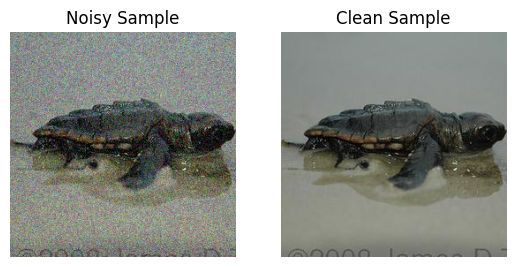

In [ ]:
# --- Load Training Data ---

print(f"Loading clean training images from: {TRAIN_IMG_DIR}")
train_image_paths = glob.glob(os.path.join(TRAIN_IMG_DIR, '*.[jJ][pP][gG]')) \
                   + glob.glob(os.path.join(TRAIN_IMG_DIR, '*.[pP][nN][gG]')) \
                   + glob.glob(os.path.join(TRAIN_IMG_DIR, '*.[tT][iI][fF][fF]')) # Add more extensions if needed

if not train_image_paths:
    print(f"Error: No images found in {TRAIN_IMG_DIR}. Please check the path and image files.")
    raise FileNotFoundError(f"No training images found in {TRAIN_IMG_DIR}")

clean_train_tensors = []
for path in tqdm(train_image_paths, desc="Preprocessing Training Images"):
    tensor = preprocess_image(path, IMG_SIZE)
    if tensor is not None:
        clean_train_tensors.append(tensor)

print(f"Successfully loaded and preprocessed {len(clean_train_tensors)} training images.")

# Create Dataset and DataLoader
train_dataset = DenoisingDataset(clean_train_tensors, NOISE_TYPE, NOISE_LEVEL)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0) 

# Display a sample pair
noisy_sample, clean_sample = train_dataset[0]
fig, ax = plt.subplots(1, 2)
ax[0].imshow(noisy_sample.permute(1, 2, 0))
ax[0].set_title('Noisy Sample')
ax[0].axis('off')
ax[1].imshow(clean_sample.permute(1, 2, 0))
ax[1].set_title('Clean Sample')
ax[1].axis('off')
plt.show()

## Section 2: Model Training and Saving

In [ ]:
# --- Define CNN Model  ---
class DenoisingCNN(nn.Module):
    def __init__(self, n_chan=3, chan_embed=48):
        super().__init__()
        self.act = nn.LeakyReLU(negative_slope=0.2, inplace=True)
        self.conv1 = nn.Conv2d(n_chan, chan_embed, 3, padding=1)
        self.conv2 = nn.Conv2d(chan_embed, chan_embed, 3, padding=1)
        self.conv3 = nn.Conv2d(chan_embed, n_chan, 1)

    def forward(self, x):
        x1 = self.act(self.conv1(x))
        x2 = self.act(self.conv2(x1))
        output = self.conv3(x2)
        return output


In [ ]:
# --- Training Setup ---
model = DenoisingCNN(n_chan=3).to(device) 
criterion = nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print(f"Model Parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

Model Parameters: 22275


Starting Training...


Epoch 1/50:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1/50, Average Loss: 0.044857


Epoch 2/50:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2/50, Average Loss: 0.005703


Epoch 3/50:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3/50, Average Loss: 0.003974


Epoch 4/50:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4/50, Average Loss: 0.003362


Epoch 5/50:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5/50, Average Loss: 0.002974


Epoch 6/50:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 6/50, Average Loss: 0.002750


Epoch 7/50:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 7/50, Average Loss: 0.002602


Epoch 8/50:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 8/50, Average Loss: 0.002503


Epoch 9/50:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 9/50, Average Loss: 0.002422


Epoch 10/50:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10/50, Average Loss: 0.002352


Epoch 11/50:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 11/50, Average Loss: 0.002293


Epoch 12/50:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 12/50, Average Loss: 0.002246


Epoch 13/50:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 13/50, Average Loss: 0.002208


Epoch 14/50:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 14/50, Average Loss: 0.002161


Epoch 15/50:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 15/50, Average Loss: 0.002124


Epoch 16/50:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 16/50, Average Loss: 0.002092


Epoch 17/50:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 17/50, Average Loss: 0.002060


Epoch 18/50:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 18/50, Average Loss: 0.002028


Epoch 19/50:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 19/50, Average Loss: 0.002009


Epoch 20/50:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 20/50, Average Loss: 0.001982


Epoch 21/50:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 21/50, Average Loss: 0.001941


Epoch 22/50:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 22/50, Average Loss: 0.001913


Epoch 23/50:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 23/50, Average Loss: 0.001900


Epoch 24/50:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 24/50, Average Loss: 0.001865


Epoch 25/50:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 25/50, Average Loss: 0.001841


Epoch 26/50:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 26/50, Average Loss: 0.001822


Epoch 27/50:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 27/50, Average Loss: 0.001794


Epoch 28/50:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 28/50, Average Loss: 0.001768


Epoch 29/50:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 29/50, Average Loss: 0.001743


Epoch 30/50:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 30/50, Average Loss: 0.001717


Epoch 31/50:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 31/50, Average Loss: 0.001713


Epoch 32/50:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 32/50, Average Loss: 0.001688


Epoch 33/50:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 33/50, Average Loss: 0.001658


Epoch 34/50:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 34/50, Average Loss: 0.001635


Epoch 35/50:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 35/50, Average Loss: 0.001624


Epoch 36/50:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 36/50, Average Loss: 0.001628


Epoch 37/50:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 37/50, Average Loss: 0.001591


Epoch 38/50:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 38/50, Average Loss: 0.001581


Epoch 39/50:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 39/50, Average Loss: 0.001577


Epoch 40/50:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 40/50, Average Loss: 0.001564


Epoch 41/50:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 41/50, Average Loss: 0.001551


Epoch 42/50:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 42/50, Average Loss: 0.001538


Epoch 43/50:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 43/50, Average Loss: 0.001526


Epoch 44/50:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 44/50, Average Loss: 0.001526


Epoch 45/50:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 45/50, Average Loss: 0.001510


Epoch 46/50:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 46/50, Average Loss: 0.001506


Epoch 47/50:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 47/50, Average Loss: 0.001495


Epoch 48/50:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 48/50, Average Loss: 0.001499


Epoch 49/50:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 49/50, Average Loss: 0.001500


Epoch 50/50:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 50/50, Average Loss: 0.001497
Training Finished.


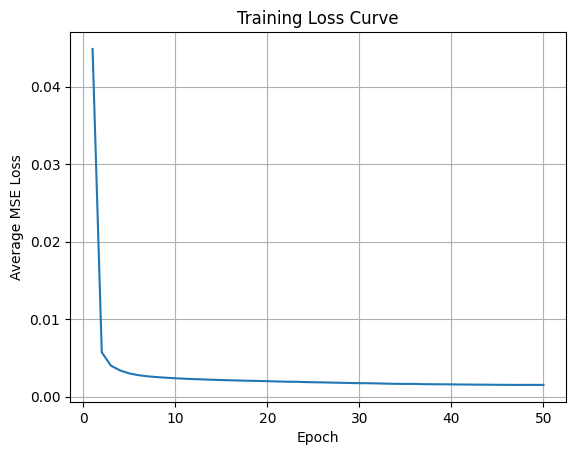

In [ ]:
# --- Training Loop ---
print("Starting Training...")
model.train()
epoch_losses = []

for epoch in range(EPOCHS):
    running_loss = 0.0
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=False)

    for noisy_batch, clean_batch in progress_bar:
        noisy_batch = noisy_batch.to(device)
        clean_batch = clean_batch.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        predicted_clean_batch = model(noisy_batch)

        # loss
        loss = criterion(predicted_clean_batch, clean_batch)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * noisy_batch.size(0)
        progress_bar.set_postfix(loss=loss.item())

    epoch_loss = running_loss / len(train_dataset)
    epoch_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{EPOCHS}, Average Loss: {epoch_loss:.6f}")


print("Training Finished.")

# Plot training loss
plt.figure()
plt.plot(range(1, EPOCHS + 1), epoch_losses)
plt.xlabel('Epoch')
plt.ylabel('Average MSE Loss')
plt.title('Training Loss Curve')
plt.grid(True)
plt.show()


In [10]:
# --- Save the Trained Model ---
model_save_filename = f"{NOISE_TYPE}_cnn_n2n_nl{NOISE_LEVEL}.pth"
model_save_path = os.path.join(MODEL_SAVE_DIR, model_save_filename)

print(f"Saving trained model to: {model_save_path}")
torch.save(model.state_dict(), model_save_path)
print("Model saved successfully.")



Saving trained model to: /kaggle/working/gauss_cnn_n2n_nl25.pth
Model saved successfully.


## Section 3: Testing on a Single Image

In [ ]:
# --- Parameters for Testing ---
TEST_IMAGE_PATH = "/kaggle/input/aiml-project/491.jpg"
SAVED_MODEL_FILENAME = f"{NOISE_TYPE}_cnn_n2n_nl{NOISE_LEVEL}.pth"
SAVED_MODEL_PATH = os.path.join(MODEL_SAVE_DIR, SAVED_MODEL_FILENAME)

TEST_IMAGE_IS_ALREADY_NOISY = False 
TEST_NOISE_TYPE = NOISE_TYPE           
TEST_NOISE_LEVEL = NOISE_LEVEL               


In [ ]:
# --- Load Saved Model ---
print(f"Loading model from: {SAVED_MODEL_PATH}")
test_model = DenoisingCNN(n_chan=3).to(device)
try:
    test_model.load_state_dict(torch.load(SAVED_MODEL_PATH, map_location=device))
    test_model.eval()
    print("Model loaded successfully.")
except FileNotFoundError:
    print(f"Error: Model file not found at {SAVED_MODEL_PATH}. Did Section 2 run correctly?")
    raise FileNotFoundError(f"Model file not found at {SAVED_MODEL_PATH}")
except Exception as e:
     print(f"Error loading model state_dict: {e}")
     raise e

Loading model from: /kaggle/working/gauss_cnn_n2n_nl25.pth
Model loaded successfully.


/tmp/ipykernel_31/1946807162.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model.load_state_dict(torch.load(SAVED_MODEL_PATH, map_location=device))


In [ ]:
# --- Load and Prepare Test Image ---
print(f"Loading test image: {TEST_IMAGE_PATH}")
if not os.path.exists(TEST_IMAGE_PATH):
     print(f"Error: Test image not found at {TEST_IMAGE_PATH}")
     raise FileNotFoundError(f"Test image not found at {TEST_IMAGE_PATH}")

input_tensor = preprocess_image(TEST_IMAGE_PATH, IMG_SIZE)

if input_tensor is None:
    print("Failed to process test image.")
    raise ValueError("Test image processing failed.")

input_tensor = input_tensor.to(device)
original_for_display = input_tensor.cpu().clone() 

# --- Add Noise ---
if not TEST_IMAGE_IS_ALREADY_NOISY:
    print(f"Adding {TEST_NOISE_TYPE} noise (level {TEST_NOISE_LEVEL}) to the test image.")
    noisy_input_tensor = add_noise(input_tensor, TEST_NOISE_TYPE, TEST_NOISE_LEVEL)
else:
    print("Test image is assumed to be already noisy. Skipping noise addition.")
    noisy_input_tensor = input_tensor

noisy_input_batch = noisy_input_tensor.unsqueeze(0)

Loading test image: /kaggle/input/aiml-project/491.jpg
Adding gauss noise (level 25) to the test image.


In [ ]:
# --- Perform Denoising ---
print("Denoising the image...")
with torch.no_grad():
    denoised_output_batch = test_model(noisy_input_batch)

denoised_output_tensor = torch.clamp(denoised_output_batch.squeeze(0), 0.0, 1.0)
print("Denoising complete.")

Denoising the image...
Denoising complete.


Displaying Images - PSNR (Noisy vs Clean): 20.47 dB
Displaying Images - PSNR (Denoised vs Clean): 26.19 dB


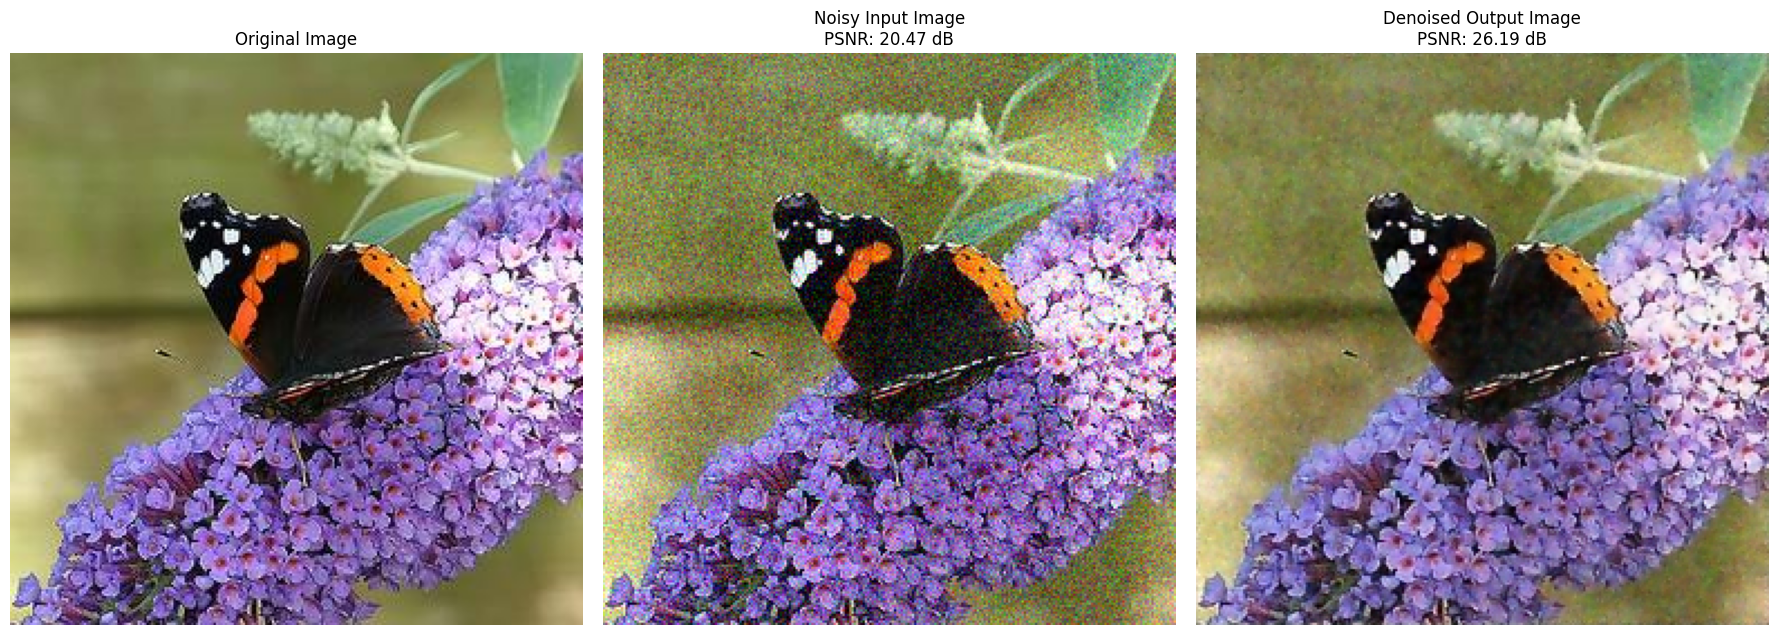

In [ ]:
# --- Calculate PSNR Values for Display ---
clean_tensor_device = original_for_display.to(device)

# Calculate PSNR for Noisy vs Clean
mse_noisy = F.mse_loss(noisy_input_tensor, clean_tensor_device)
if mse_noisy.item() > 1e-10: 
    psnr_noisy = 10 * torch.log10(1.0 / mse_noisy).item()
else:
    psnr_noisy = float('inf')

# Calculate PSNR for Denoised vs Clean
mse_denoised = F.mse_loss(denoised_output_tensor, clean_tensor_device)
if mse_denoised.item() > 1e-10: 
    psnr_denoised = 10 * torch.log10(1.0 / mse_denoised).item()
else:
    psnr_denoised = float('inf')

print(f"Displaying Images - PSNR (Noisy vs Clean): {psnr_noisy:.2f} dB")
print(f"Displaying Images - PSNR (Denoised vs Clean): {psnr_denoised:.2f} dB")


# --- Display Results ---

original_display_np = original_for_display.permute(1, 2, 0).numpy()
noisy_display_np = noisy_input_tensor.cpu().permute(1, 2, 0).numpy()
denoised_display_np = denoised_output_tensor.cpu().permute(1, 2, 0).numpy()

fig, ax = plt.subplots(1, 3, figsize=(18, 7))

# Display Original Image
ax[0].imshow(np.clip(original_display_np, 0, 1))
ax[0].set_title('Original Image')
ax[0].axis('off')

# Display Noisy Image with PSNR
ax[1].imshow(np.clip(noisy_display_np, 0, 1))
title_noisy = f'Noisy Input Image\nPSNR: {psnr_noisy:.2f} dB'
ax[1].set_title(title_noisy)
ax[1].axis('off')

# Display Denoised Image with PSNR
ax[2].imshow(np.clip(denoised_display_np, 0, 1))
title_denoised = f'Denoised Output Image\nPSNR: {psnr_denoised:.2f} dB'
ax[2].set_title(title_denoised)
ax[2].axis('off')

plt.tight_layout(pad=1.5)
plt.show()


In [ ]:
import os
import time
import pandas as pd
import numpy as np

import torch
import torch.nn as nn 
import torch.nn.functional as F 

N_CHAN = 3 #(RGB)

TEST_IMG_DIR = '/kaggle/input/aiml-project/test_images_50'
CSV_OUTPUT_FILENAME = f'{NOISE_TYPE}_cnn_n2n_nl{NOISE_LEVEL}.csv'

TEST_NOISE_TYPE = NOISE_TYPE      
TEST_NOISE_LEVEL = NOISE_LEVEL    

# --- Construct Model Path (using assumed variables) ---
SAVED_MODEL_FILENAME = f"{NOISE_TYPE}_cnn_n2n_nl{NOISE_LEVEL}.pth"
SAVED_MODEL_PATH = os.path.join(MODEL_SAVE_DIR, SAVED_MODEL_FILENAME)

# --- Load Saved Model (Once) ---
print(f"Loading model from: {SAVED_MODEL_PATH}")
test_model = DenoisingCNN(n_chan=N_CHAN).to(device)
try:
    # Load the learned weights
    test_model.load_state_dict(torch.load(SAVED_MODEL_PATH, map_location=device))
    test_model.eval() 
    print("Model loaded successfully.")
except FileNotFoundError:
    print(f"Error: Model file not found at {SAVED_MODEL_PATH}. Ensure the path and filename are correct.")
    raise FileNotFoundError(f"Model file not found at {SAVED_MODEL_PATH}")
except Exception as e:
      print(f"Error loading model state_dict: {e}")
      raise e

# --- Prepare for Batch Processing ---
if not os.path.isdir(TEST_IMG_DIR):
    print(f"Error: Test image directory not found: {TEST_IMG_DIR}")
    raise FileNotFoundError(f"Test image directory not found: {TEST_IMG_DIR}")

image_extensions = ('.jpg', '.jpeg', '.png')
try:
    all_files = os.listdir(TEST_IMG_DIR)
    image_files = sorted([f for f in all_files if f.lower().endswith(image_extensions)])
except Exception as e:
    print(f"Error listing files in {TEST_IMG_DIR}: {e}")
    raise

if not image_files:
    print(f"No image files with extensions {image_extensions} found in {TEST_IMG_DIR}")
    exit() 

print(f"Found {len(image_files)} images to process in {TEST_IMG_DIR}.")

results_data = [] # List holds {'filename': ..., 'psnr_db': ...} dictionaries

print("\nStarting batch denoising and PSNR calculation...")
start_time = time.time()

for filename in image_files:
    current_image_path = os.path.join(TEST_IMG_DIR, filename)

    try:
        clean_input_tensor = preprocess_image(current_image_path, IMG_SIZE)
        if clean_input_tensor is None:
            print(f"  Skipping {filename} due to preprocessing error.")
            results_data.append({'filename': filename, 'psnr_db': np.nan}) # Record error
            continue 

        clean_input_tensor = clean_input_tensor.to(device)

        noisy_input_tensor = add_noise(clean_input_tensor, TEST_NOISE_TYPE, TEST_NOISE_LEVEL)

        noisy_input_batch = noisy_input_tensor.unsqueeze(0)

        with torch.no_grad():
            denoised_output_batch = test_model(noisy_input_batch)

        denoised_output_tensor = torch.clamp(denoised_output_batch.squeeze(0), 0.0, 1.0)

        # --- Calculate PSNR (Denoised vs Original Clean) ---
        mse_loss = F.mse_loss(denoised_output_tensor, clean_input_tensor)

        # Calculate PSNR
        if mse_loss.item() > 1e-10: 
            psnr = 10 * torch.log10(1.0 / mse_loss)
            current_psnr = psnr.item()
        else:
            current_psnr = float('inf')


        # --- Store Result ---
        results_data.append({'filename': filename, 'psnr_db': current_psnr})

    except Exception as e:
        print(f"  Error processing {filename}: {e}")
        results_data.append({'filename': filename, 'psnr_db': np.nan})

end_time = time.time() 
print(f"\nBatch processing completed in {end_time - start_time:.2f} seconds.")

# --- Calculate Average PSNR and Save Results ---
if results_data:
    results_df = pd.DataFrame(results_data)

    valid_psnr_values = results_df['psnr_db'].replace([np.inf, -np.inf], np.nan).dropna()

    if not valid_psnr_values.empty:
        average_psnr = valid_psnr_values.mean()
        print(f"\nAverage PSNR over {len(valid_psnr_values)} successfully processed images: {average_psnr:.2f} dB")
    else:
        average_psnr = np.nan
        print("\nCould not calculate average PSNR (no valid results).")

    try:
        results_df.to_csv(CSV_OUTPUT_FILENAME, index=False)
        print(f"Results saved to {CSV_OUTPUT_FILENAME}")
    except Exception as e:
        print(f"Error saving results to CSV ({CSV_OUTPUT_FILENAME}): {e}")
else:
    print("No images were processed.")

print("\nScript finished.")

Loading model from: /kaggle/working/gauss_cnn_n2n_nl25.pth
Model loaded successfully.
Found 50 images to process in /kaggle/input/aiml-project/test_images_50.

Starting batch denoising and PSNR calculation...


/tmp/ipykernel_31/163305715.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model.load_state_dict(torch.load(SAVED_MODEL_PATH, map_location=device))



Batch processing completed in 0.42 seconds.

Average PSNR over 50 successfully processed images: 28.36 dB
Results saved to gauss_cnn_n2n_nl25.csv

Script finished.
